# Assignment 4.2 - Independent Component Analysis

Please submit your solution of this notebook in the Whiteboard at the corresponding Assignment entry as .ipynb-file and as .pdf. <br><br>
Please do **NOT** rename the file!

#### State both names of your group members here:
[Jane and John Doe]

In [1]:
# Daniel Thompson, Paola Gega

---

## Grading Info/Details - Assignment 4.2:

The assignment will be graded semi-automatically, which means that your code will be tested against a set of predefined test cases and qualitatively assessed by a human. This will speed up the grading process for us.

* For passing the test scripts: 
    - Please make sure to **NOT** alter predefined class or function names, as this would lead to failing of the test scripts.
    - Please do **NOT** rename the files before uploading to the Whiteboard!

* **(RESULT)** tags indicate checkpoints that will be specifically assessed by a human.

* You will pass the assignment if you pass the majority of test cases and we can at least confirm effort regarding the **(RESULT)**-tagged checkpoints per task.

---

## Task 4.2.1 - ICA

Implement Independent Component Analysis (ICA) from scratch using only `NumPy`. Feel free to use the `FastICA` algorithm as reference. You may check the tutorial slides for a breakdown of the algorithm.<br><br>
You are welcome to use `sklearn`'s PCA implementation for data whitening.

* Implement the ICA given the class structure below. **(RESULT)**
* Test your implementation using test signals (e.g. sinewave, squarewave like the lecture example) and plot the signal waves before and after ICA. **(RESULT)**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# from typing import Optional, Callable, Tuple

In [3]:
class ICA:
    """
    Independent Component Analysis (ICA) using the FastICA algorithm.
    
    ICA is a computational method for separating a multivariate signal into
    additive subcomponents, assuming that the subcomponents are statistically
    independent and non-Gaussian.
    
    """
    
    def __init__(
        self,
        n_components = None,
        max_iter = 1000,
        tol = 1e-6,
        w_init = None,
        random_state = None,
        whiten = True
    ):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.w_ = w_init
        self.random_state = random_state
        self.whiten = whiten
    
    def fit(self, X):
        """
        Fit the ICA model to the data.

        Parameters:
        X : numpy array of shape (n_samples, n_features)
            The input data.
        """
        n_samples, self.n_features_in_ = X.shape
        # If n_components not specified, all are used
        if not self.n_components:
            self.n_components = self.n_features_in_
        
        # Preprocessing phase: centers data 
        self.pca_ = PCA(
            n_components=self.n_features_in_,
            whiten = self.whiten,
            random_state=self.random_state
            )
        X = self.pca_.fit_transform(X)

        # Initialize demixing matrix w - shape (n_components, n_features)
        if not self.w_:
            self.w_ = np.eye(self.n_components, self.n_features_in_)

        # Component extraction phase
        for i in range(self.n_components):
            for it in range(self.max_iter):
                w_old = self.w_[i]
                # Fixed-point iteration using the g(u) = u^3 choice
                self.w_[i] = ( ((X @ w_old) ** 3) @ X / n_samples
                              - 3 * np.mean((X @ w_old) ** 2) * w_old)
                # Use QR decomposition to perform a Gram-Schmidt orthogonalization 
                self.w_[i] = np.linalg.qr(self.w_[:i+1].T)[0][:,i]
                if (np.abs(np.dot(self.w_[i], w_old) - 1) < self.tol):
                    break
    
    def transform(self, X):
        """
        Apply the unmixing matrix to the (centered, whitened) data.

        Parameters:
        X : numpy array of shape (n_samples, n_features)
            The input data.

        Returns:
        S_hat : numpy array of shape (n_samples, n_components)
            The latent independent source data.
        """
        return self.pca_.transform(X) @ self.w_.T
    
    def fit_transform(self, X):
        """
        Fit ICA and transform X in one step.
        """
        self.fit(X)
        return self.transform(X)
    
    def inverse_transform(self, S):
        """
        Transform the sources back to the mixed data space.

        Parameters:
        S : numpy array of shape (n_samples, n_components)
            The source data.

        Returns:
        X : numpy array of shape (n_samples, n_components)
            The mixed data.
        """
        return self.pca_.inverse_transform(S @ self.w_)

In [4]:
def generate_test_signals(n_samples: int = 2000, random_state: int = 42):
    """
    Generate test signals for ICA demonstration.
    """
    np.random.seed(random_state)
    t = np.linspace(0, 8, n_samples)
    s1 = np.sin(2 * np.pi * t) + np.random.randn(n_samples)/4  # Sine wave
    s2 = np.sign(np.sin(3 * np.pi * t)) + np.random.randn(n_samples)/4  # Square wave

    # Mix the signals
    S = np.c_[s1, s2]
    A = np.array([[1, 1], [-1, 1]])
    X = S @ A.T  # Mixed signals
    print("Shape of mixed signals X: ", X.shape)
    return X, S

Shape of mixed signals X:  (2000, 2)


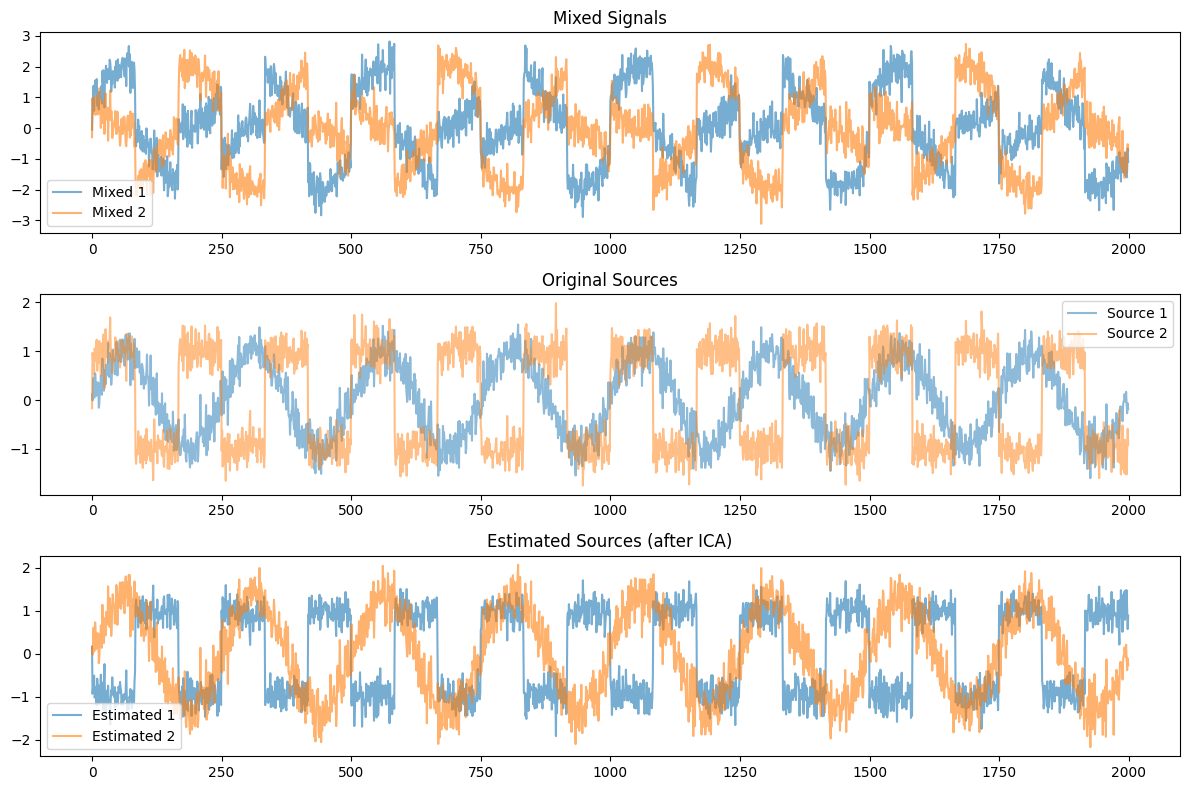

In [5]:
# test the ICA implementation

X, S = generate_test_signals()

# fit the model
ica = ICA(n_components=2)
ica.fit(X)
S_ = ica.transform(X)

# plot the results
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.title("Mixed Signals")
plt.plot(X, alpha=0.6)
plt.legend(["Mixed 1", "Mixed 2", "Mixed 3"])

plt.subplot(3, 1, 2)
plt.title("Original Sources")
plt.plot(S, alpha=0.5)
plt.legend(["Source 1", "Source 2", "Source 3"])

plt.subplot(3, 1, 3)
plt.title("Estimated Sources (after ICA)")
plt.plot(S_, alpha=0.6)
plt.legend(["Estimated 1", "Estimated 2", "Estimated 3"])

plt.tight_layout()
plt.show()

## Task 4.2.2 - ICA on IRIS Dataset

* Use your ICA class on the `IRIS` dataset. **(RESULT)**
* Visualize independent input features using scatter plots. You should be able to obtain these with the fitted unmixing matrix. **(RESULT)**



In [6]:
from sklearn.datasets import load_iris

In [7]:
data = load_iris()
X_iris = data.data

irisca = ICA(n_components=4)
irisca.fit(X_iris)
S_iris = irisca.transform(X_iris)

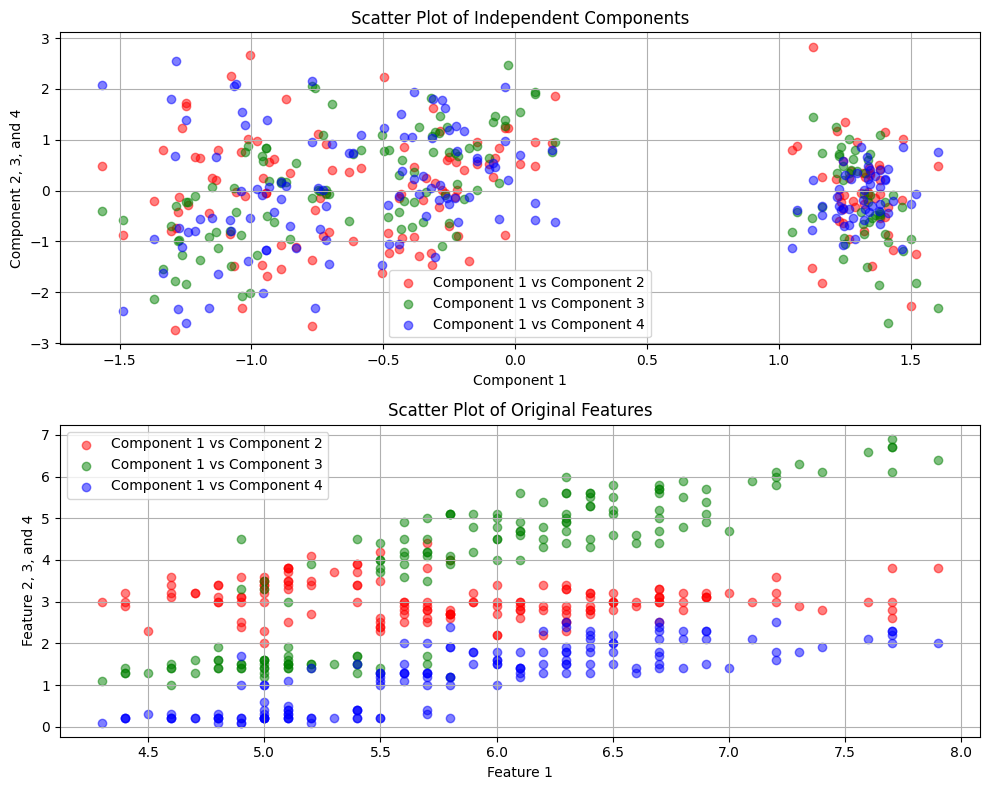

In [8]:
# scatter plot after compared to before transformation

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
# Scatter plot for Component 1 vs Component 2
plt.scatter(S_iris[:, 0], S_iris[:, 1], c='r', label='Component 1 vs Component 2', alpha=0.5)

# Overlay other components
plt.scatter(S_iris[:, 0], S_iris[:, 2], c='g', label='Component 1 vs Component 3', alpha=0.5)
plt.scatter(S_iris[:, 0], S_iris[:, 3], c='b', label='Component 1 vs Component 4', alpha=0.5)

plt.title('Scatter Plot of Independent Components')
plt.xlabel('Component 1')
plt.ylabel('Component 2, 3, and 4')

plt.legend()
plt.grid()

#------
plt.subplot(2, 1, 2)

plt.scatter(X_iris[:, 0], X_iris[:, 1], c='r', label='Component 1 vs Component 2', alpha=0.5)

# Overlay other features
plt.scatter(X_iris[:, 0], X_iris[:, 2], c='g', label='Component 1 vs Component 3', alpha=0.5)
plt.scatter(X_iris[:, 0], X_iris[:, 3], c='b', label='Component 1 vs Component 4', alpha=0.5)

plt.title('Scatter Plot of Original Features')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2, 3, and 4')

plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

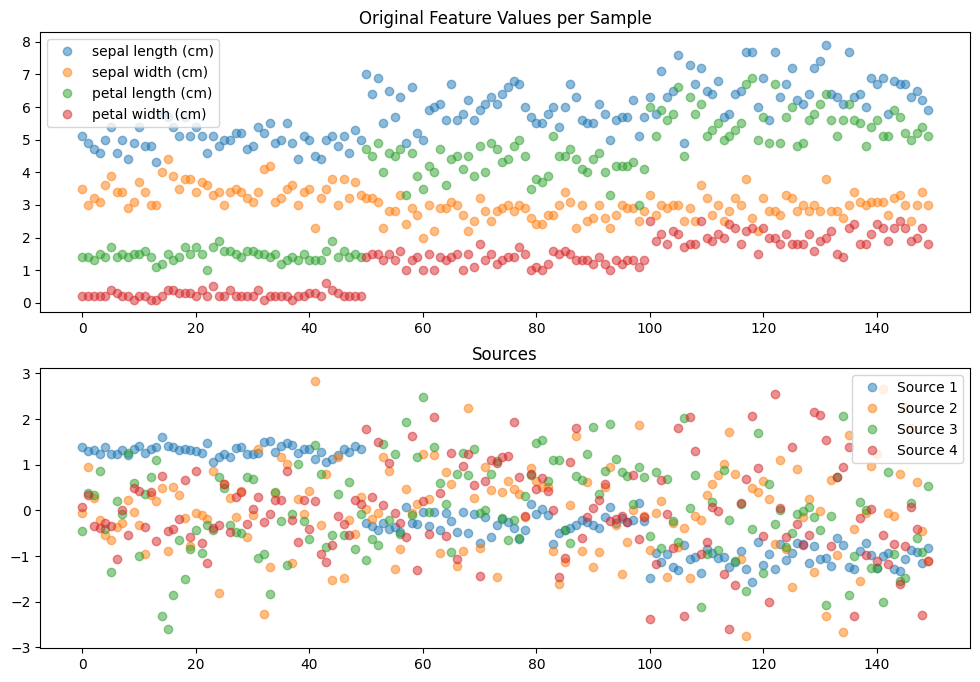

In [9]:
# plot the results
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.title("Original Feature Values per Sample")
plt.plot(X_iris, linestyle="", marker="o", alpha=0.5)
plt.legend(["sepal length (cm)", "sepal width (cm)", "petal length (cm)", "petal width (cm)"])

plt.subplot(2, 1, 2)
plt.title("Sources")
plt.plot(S_iris, linestyle="", marker="o", alpha=0.5)
plt.legend(["Source 1", "Source 2", "Source 3", "Source 4"])
plt.show()

Just for a visual reference we compare our 2-dimensional ICA projection of the Iris data to that given by the Sklearn FastICA.

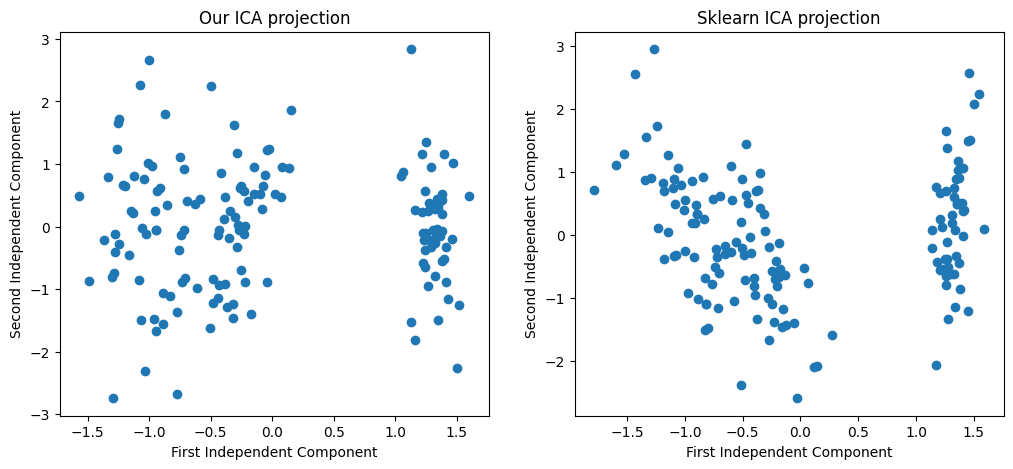

In [10]:
from sklearn.decomposition import FastICA

ica = ICA(n_components=2)
S = ica.fit_transform(X_iris)

FastICA = FastICA(n_components=2)
Skl_S = FastICA.fit_transform(X_iris)

plot_1 = plt.subplot(1, 2, 1)
plt.subplots_adjust(bottom=0.1, right=1.6, top=0.9)
plt.scatter(S[:, 0], S[:, 1])
plt.title("Our ICA projection")
plt.xlabel('First Independent Component')
plt.ylabel('Second Independent Component')

plot_2 = plt.subplot(1, 2, 2)
plt.scatter(Skl_S[:, 0], Skl_S[:, 1])
plt.title("Sklearn ICA projection")
plt.xlabel('First Independent Component')
plt.ylabel('Second Independent Component')
plt.show()

## Congratz, you made it! :)